In [1]:
%matplotlib inline

In [2]:
import sys
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import collections
import re

### Load training dataset

In [3]:
deck = {}

In [4]:
for filename in os.listdir("./train"):
    match = re.match("([0-9AJQK]+).JPG", filename)
    if not match:
        continue
    cardname = match.groups()[0]
    path = os.path.join(os.getcwd(), "train", filename)
    img = cv2.imread(path)
    deck[cardname] = img

In [25]:
keypoints = {}
descriptors = {}

In [24]:
surf = cv2.xfeatures2d.SURF_create()

In [26]:
for cardname, img in deck.items():
    kpt, des = surf.detectAndCompute(img, None)
    keypoints[cardname] = kpt
    descriptors[cardname] = des

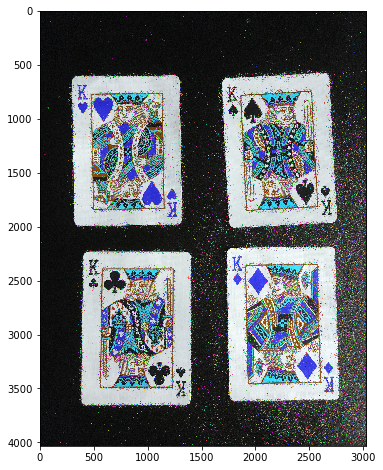

In [28]:
img = cv2.drawKeypoints(deck["K"], keypoints["K"], None)
plt.figure(figsize=(6, 8))
plt.imshow(img)

In [174]:
def diff(img1, img2):
    kpt1, des1 = surf.detectAndCompute(img1, None)
    kpt2, des2 = surf.detectAndCompute(img2, None)
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    print("Total matches: {}".format(len(matches)))
    # Apply ratio test
    good = []
    ratio = 0.75
    for m,n in matches:
        if m.distance < ratio * n.distance:
            good.append(m)
    print("Good matches: {}".format(len(good)))
    #img3 = cv2.drawMatchesKnn(img1, kpt1, img2, kpt2, good, flags=2, outImg=img2)
    #plt.imshow(img3)
    # Featured matched keypoints from images 1 and 2
    print("Getting points")
    pts1 = np.float32([kpt1[m.queryIdx].pt for m in good])
    pts2 = np.float32([kpt2[m.trainIdx].pt for m in good])
    # Convert x, y coordinates into complex numbers
    print("Converting")
    z1 = np.array([[complex(c[0],c[1]) for c in pts1]])
    z2 = np.array([[complex(c[0],c[1]) for c in pts2]])
    # Distance between featured matched keypoints
    print("Calculating distance")
    print(z2.shape, z1.shape)
    dist = np.abs(z2 - z1)
    return dist

### Try extracting cards first

In [5]:
def rectify(h):
  # print(h.shape)
  # print(len(h))
  h = h.reshape((4,2))
  hnew = np.zeros((4,2),dtype = np.float32)

  add = h.sum(1)
  hnew[0] = h[np.argmin(add)]
  hnew[2] = h[np.argmax(add)]
   
  diff = np.diff(h,axis = 1)
  hnew[1] = h[np.argmin(diff)]
  hnew[3] = h[np.argmax(diff)]

  return hnew

def preprocess(img):
  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  blur = cv2.GaussianBlur(gray,(5,5),2 )
  thresh = cv2.adaptiveThreshold(blur,255,1,1,11,1)
  return thresh

In [90]:
def getCards(im, numcards=1):
  gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
  blur = cv2.GaussianBlur(gray,(1,1),1000)
  flag, thresh = cv2.threshold(blur, 90, 255, cv2.THRESH_BINARY) 
  plt.imshow(thresh)
       
  _, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

  contours = sorted(contours, key=cv2.contourArea,reverse=True)[:numcards]  

  for card in contours:
    peri = cv2.arcLength(card,True)
    approx = rectify(cv2.approxPolyDP(card,0.02*peri,True))  
    
    h = np.array([ [0,0],[449,0],[449,449],[0,449] ],np.float32)

    transform = cv2.getPerspectiveTransform(approx,h)
    warp = cv2.warpPerspective(im,transform,(450,450))
    
    yield warp

In [7]:
deck = collections.defaultdict(list)

In [8]:
for filename in os.listdir("./train"):
    if filename.endswith(".JPG"):
        cardname = filename[:-4]
        path = os.path.join(os.getcwd(), "train", filename)
        img = cv2.imread(path)
        for card in getCards(img, 4):
            deck[cardname].append(card)

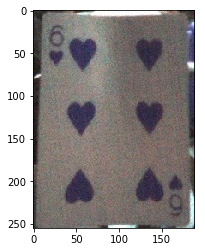

In [83]:
test = cv2.imread("/Users/pawel/blackjack/cards/test/baxter3.jpg")
plt.imshow(test)

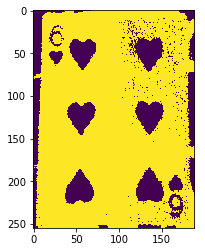

In [91]:
test_card = next(getCards(test))
#plt.imshow(test_card)

In [92]:
for card in deck.keys():
    print(card)
    match = lambda template: cv2.matchTemplate(test_card,template,cv2.TM_SQDIFF_NORMED)
    res = min(map(match, deck[card]))[0][0]
    print(res)

A
0.42150396
3
0.4551525
K
0.44206482
2
0.42552605
J
0.42070594
9
0.42592555
4
0.3932827
Q
0.42726293
8
0.42417666
10
0.41646427
7
0.42382476
5
0.3991973
6
0.41207537
